In [1]:
import matplotlib.pyplot as plt
import cv2
import os
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.applications import *
from keras.layers import *
from keras.datasets import cifar10,cifar100
from keras.callbacks import *
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from keras.engine.topology import Layer
from keras.optimizers import *

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

config = tf.ConfigProto()  
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
# 设置session
KTF.set_session(sess)

BATCH_SIZE=256
INPUT_SIZE=96
SEED=0

/ada/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/ada/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def preprocess(x):
    x=[cv2.resize(i,(INPUT_SIZE,INPUT_SIZE)) for i in x]
    x=np.array(x)
    return x

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
X_train=preprocess(X_train)
X_test=preprocess(X_test)

In [3]:
def residual_unit(input_tensor, kernel_size=3, filters=None, strides=1):
    """3*3->3*3 or 1*1->3*3->1*1 pre-activation block"""
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
    input_filters=K.int_shape(input_tensor)[bn_axis]
    if filters is not None and len(filters)==3:
        filters1, filters2, filters3 = filters
    else:
        filters1 = filters2 = input_filters//4
        filters3 = input_filters
        
    x = BatchNormalization(axis=bn_axis)(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(filters1, (1,1), use_bias=False)(x)

    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters2, kernel_size, strides=strides, padding='same', use_bias=False)(x)
    
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters3, (1,1))(x)
        
#     x = BatchNormalization(axis=bn_axis)(input_tensor)
#     x = Activation('relu')(x)
#     x = Conv2D(filters3, kernel_size, strides=strides, padding='same', use_bias=False)(x)

#     x = BatchNormalization(axis=bn_axis)(x)
#     x = Activation('relu')(x)
#     x = Conv2D(filters3, kernel_size, padding='same')(x)

    shortcut = input_tensor
    if input_filters != filters3 or strides != 1:
        shortcut=Conv2D(filters3,(1,1),strides=strides)(shortcut)
    
    x = add([x, shortcut])
    return x

class Interpolation2D(Layer):
    def __init__(self, resize_factor=2, **kwargs):
        super(Interpolation2D,self).__init__(**kwargs)
        self.resize_factor=int(resize_factor)
        
    def call(self,x,mask=None):
        old_height,old_width=x.shape[1],x.shape[2]
        new_width=old_width*self.resize_factor
        new_height=old_height*self.resize_factor
        # Method defaults to ResizeMethod.BILINEAR
        return tf.image.resize_images(images=x,size=(new_height,new_width))
    
    def compute_output_shape(self,input_shape):
        return (input_shape[0],
                input_shape[1]*self.resize_factor,
                input_shape[2]*self.resize_factor,
                input_shape[3])

def attention_unit(input_tensor,encoder_depth=3,p=1,t=2,r=1,stage=None):
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
    input_filters=K.int_shape(input_tensor)[bn_axis]
    x=input_tensor
    for _ in range(p):
        x=residual_unit(x)
    trunk=x
    for _ in range(t):
        trunk=residual_unit(trunk)
    trunk=Lambda(lambda x:x,name='trunk_output_%s'%stage)(trunk)
    mask=x
    # encoder
    mask=MaxPooling2D()(mask)
    for _ in range(r):
        mask=residual_unit(mask)
    skip_connections=[]
    for _ in range(encoder_depth-1):
        skip_connections.append(mask)
        mask=MaxPooling2D()(mask)
        for _ in range(r):
            mask=residual_unit(mask)
    # decoder
    skip_connections=reversed(skip_connections)
    for _,shortcut in zip(range(encoder_depth-1),skip_connections):
        for _ in range(r):
            mask=residual_unit(mask)
        mask=Interpolation2D()(mask)
        mask=add([mask,residual_unit(shortcut)])
    for _ in range(r):
        mask=residual_unit(mask)
    mask=Interpolation2D()(mask)
    # todo
    mask=BatchNormalization()(mask)
    mask=Activation('relu')(mask)
    mask=Conv2D(input_filters,(1,1),strides=1,use_bias=False)(mask)
    mask=BatchNormalization()(mask)
    mask=Activation('relu')(mask)
    mask=Conv2D(input_filters,(1,1),strides=1,use_bias=False)(mask)
    mask=Activation('sigmoid',name='gating_%s'%stage)(mask)
    # (1+Mask)*Trunk
    mask=Lambda(lambda x:x+1)(mask)
    x=multiply([trunk,mask],name='masked_output_%s'%stage)
    for _ in range(p):
        x=residual_unit(x)
    return x

In [4]:
def ResidualAttentionNet(input_shape,num_class=100,depth=56):
    num_attention_units=[1,1,1] if depth<=56 else [1,2,3]
    residual_unit_filters=[[16,16,64],
                           [32,32,128],
                           [64,64,256],
                           [128,128,512]]
    inputs=Input(input_shape)
    body=Lambda(lambda x:(x-127.5)*0.0078125,name='preprocess')(inputs)
    body=Conv2D(16,(3,3),strides=1,padding='same',use_bias=False)(body)
    body=BatchNormalization()(body)
    body=Activation('relu')(body)
    body=MaxPooling2D((3,3),strides=(2,2),padding='same')(body)
    body=residual_unit(body,filters=residual_unit_filters[0])
    for i in range(3):
        for j in range(num_attention_units[i]):
            body=attention_unit(body,encoder_depth=max(2-i,1),stage='%s_%s'%(i,j))
        body=residual_unit(body,filters=residual_unit_filters[i+1],strides=2)
    body=residual_unit(body,filters=residual_unit_filters[-1])
    body=residual_unit(body,filters=residual_unit_filters[-1])
    body=GlobalAvgPool2D()(body)
    body=Dropout(0.5)(body)
    fc=Dense(num_class,activation='softmax')(body)
    return Model(inputs,fc)

In [ ]:
model=ResidualAttentionNet((INPUT_SIZE,INPUT_SIZE,3),depth=56,num_class=10)
model.compile(optimizer=Adam(1e-4),loss='categorical_crossentropy',metrics=['acc'])
model.summary()

In [6]:
datagen = ImageDataGenerator(horizontal_flip=True,
#                              featurewise_center=True,
#                              featurewise_std_normalization=True,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2)
train_gen=datagen.flow(X_train,y_train,batch_size=BATCH_SIZE)
###
# test_gen = ImageDataGenerator()
# val_gen=datagen.flow(X_val,y_val,batch_size=BATCH_SIZE)
# test_gen=datagen.flow(X_test,y_test,batch_size=BATCH_SIZE)

In [24]:
model.fit_generator(generator=train_gen,
                    steps_per_epoch=train_gen.n//train_gen.batch_size+1,
                    validation_data=(X_test,y_test),
#                     validation_steps=val_gen.n//val_gen.batch_size+1,
                    epochs=111111,
                    callbacks=[ModelCheckpoint(filepath='./cifar10_4.h5',mode='max',monitor='val_acc',save_best_only=True,save_weights_only=True),
                               EarlyStopping(mode='max',monitor='val_acc',patience=50),
                               ReduceLROnPlateau(factor=0.2,min_lr=1e-6,patience=7,monitor='val_acc',mode='max',verbose=1)])

Epoch 1/111111
196/196 [==============================] - 302s 2s/step - loss: 0.0292 - acc: 0.9899 - val_loss: 0.3621 - val_acc: 0.9307
Epoch 2/111111
196/196 [==============================] - 180s 920ms/step - loss: 0.0261 - acc: 0.9909 - val_loss: 0.3683 - val_acc: 0.9314
Epoch 3/111111
196/196 [==============================] - 180s 920ms/step - loss: 0.0217 - acc: 0.9925 - val_loss: 0.3670 - val_acc: 0.9330
Epoch 4/111111
196/196 [==============================] - 180s 920ms/step - loss: 0.0222 - acc: 0.9924 - val_loss: 0.3662 - val_acc: 0.9342
Epoch 5/111111
196/196 [==============================] - 180s 916ms/step - loss: 0.0222 - acc: 0.9923 - val_loss: 0.3748 - val_acc: 0.9317
Epoch 6/111111
196/196 [==============================] - 180s 917ms/step - loss: 0.0194 - acc: 0.9934 - val_loss: 0.3725 - val_acc: 0.9324
Epoch 7/111111
 31/196 [===>..........................] - ETA: 2:21 - loss: 0.0204 - acc: 0.9932

KeyboardInterrupt: 

In [7]:
model.load_weights('./cifar10.h5')
# print('train acc: ',model.evaluate(x=X_train,y=y_train,batch_size=BATCH_SIZE))
print('test acc: ',model.evaluate(x=X_test,y=y_test,batch_size=BATCH_SIZE))

10000/10000 [==============================] - 14s 1ms/step
test acc:  [0.3662082630634308, 0.9342]


In [8]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

stage=2
resize=lambda x:cv2.resize(x,(INPUT_SIZE,INPUT_SIZE))
m=Model(model.input,[model.get_layer('trunk_output_%s_0'%stage).output,
                     model.get_layer('masked_output_%s_0'%stage).output,
                     model.get_layer('gating_%s_0'%stage).output])

def display(img,channel=0):
    preds=m.predict(np.expand_dims(img,0))
    fig,axes=plt.subplots(1,4,figsize=(18,6))
    axes=axes.flatten()
    axes[0].imshow(img)
    heatmap=np.sum(preds[-1][0],axis=-1)
    heatmap=(heatmap-heatmap.min())/(heatmap.max()-heatmap.min())
    heatmap=1-heatmap
    heatmap=np.uint8(heatmap*255)
    heatmap=resize(heatmap)
    heatmap=cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
    heatmap=cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    axes[1].imshow(heatmap)
    for i,d in enumerate(preds[:-1]):
        axes[i+2].imshow(resize(np.sum(d[0],axis=-1)))

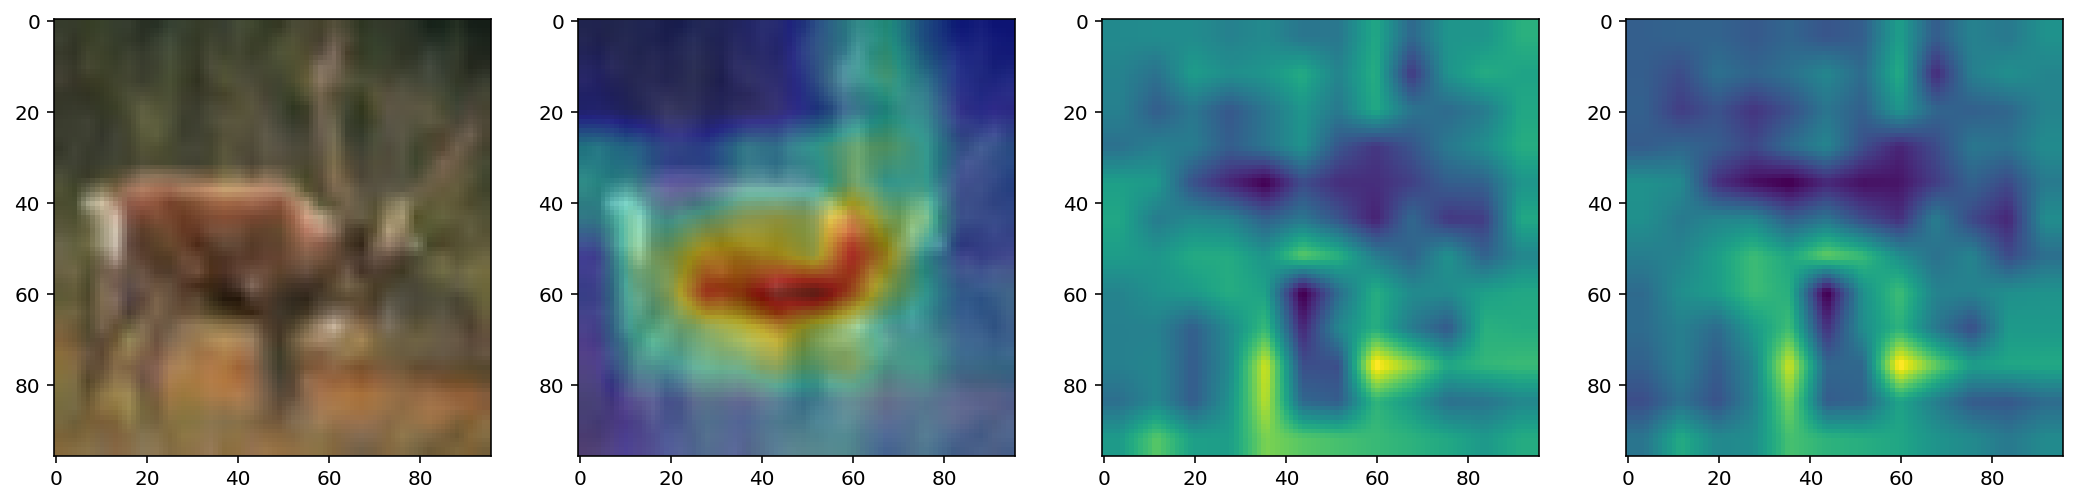

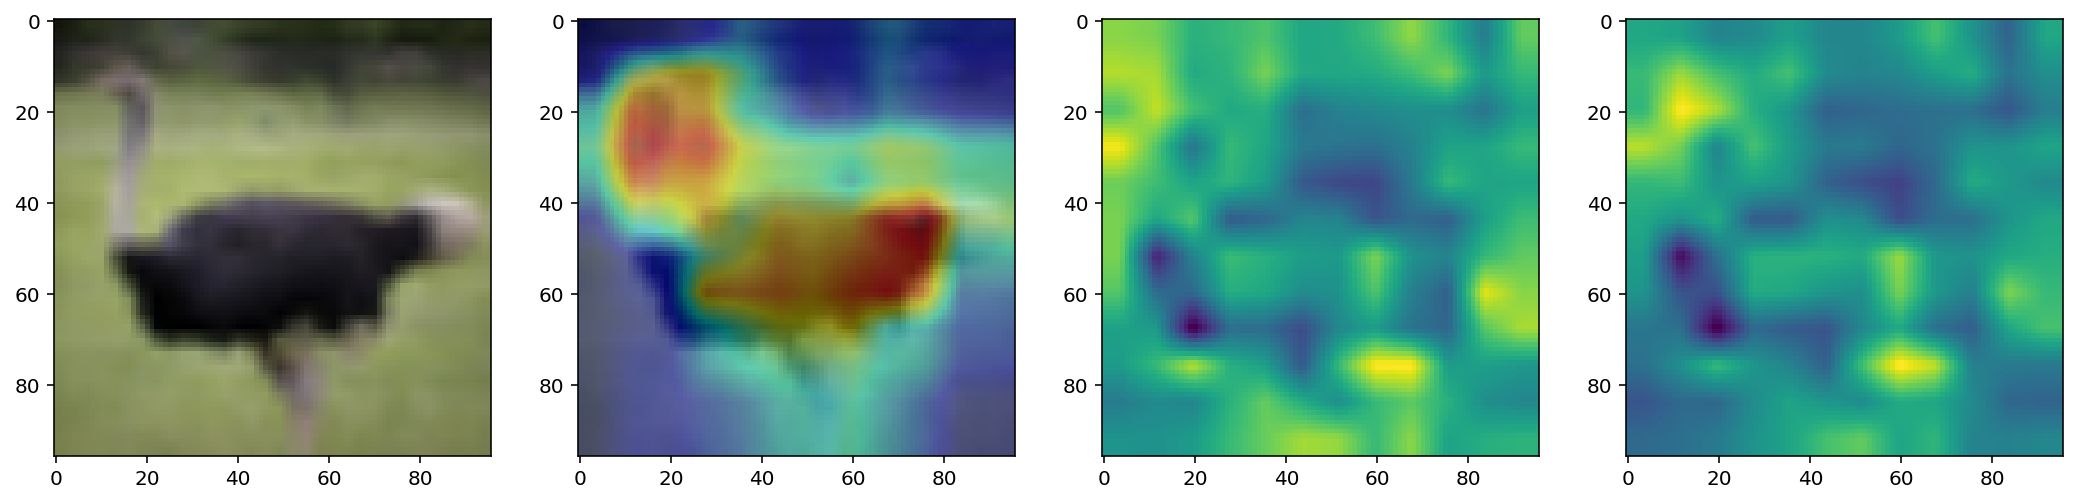

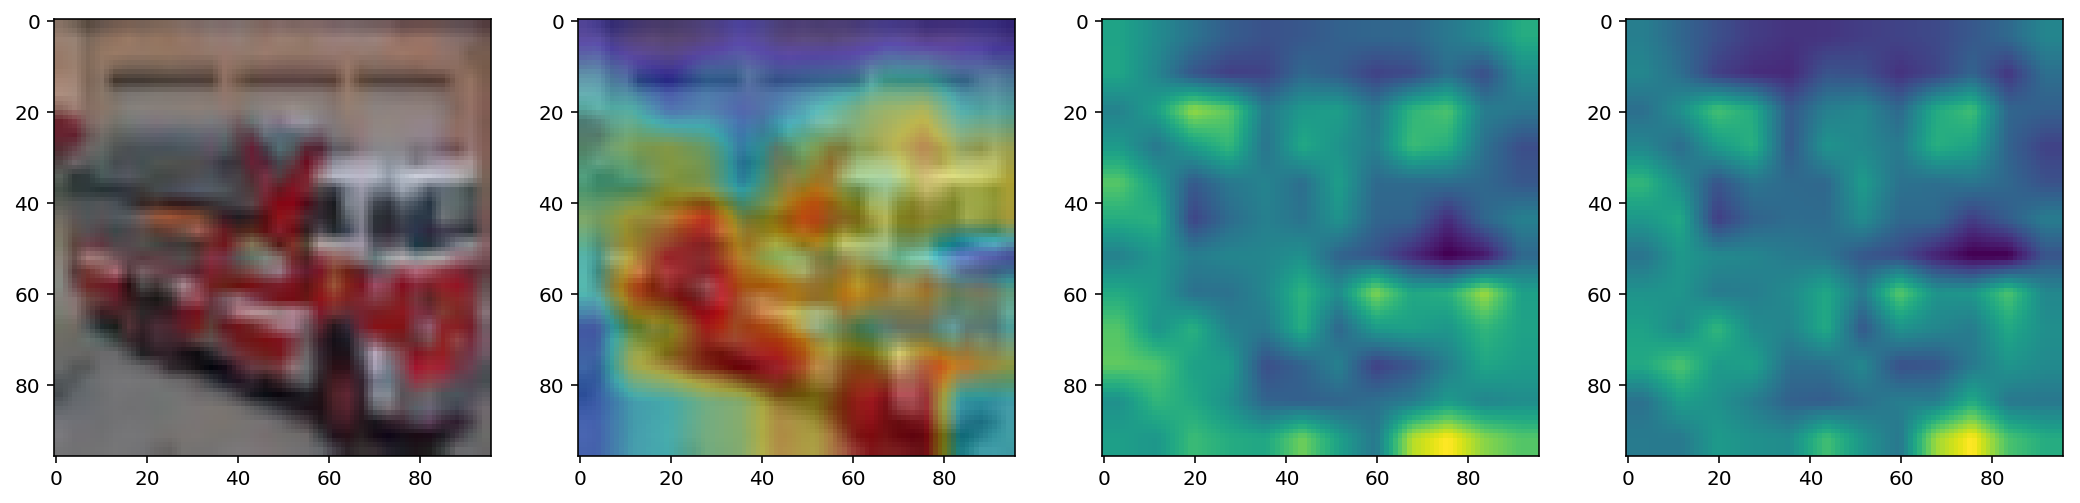

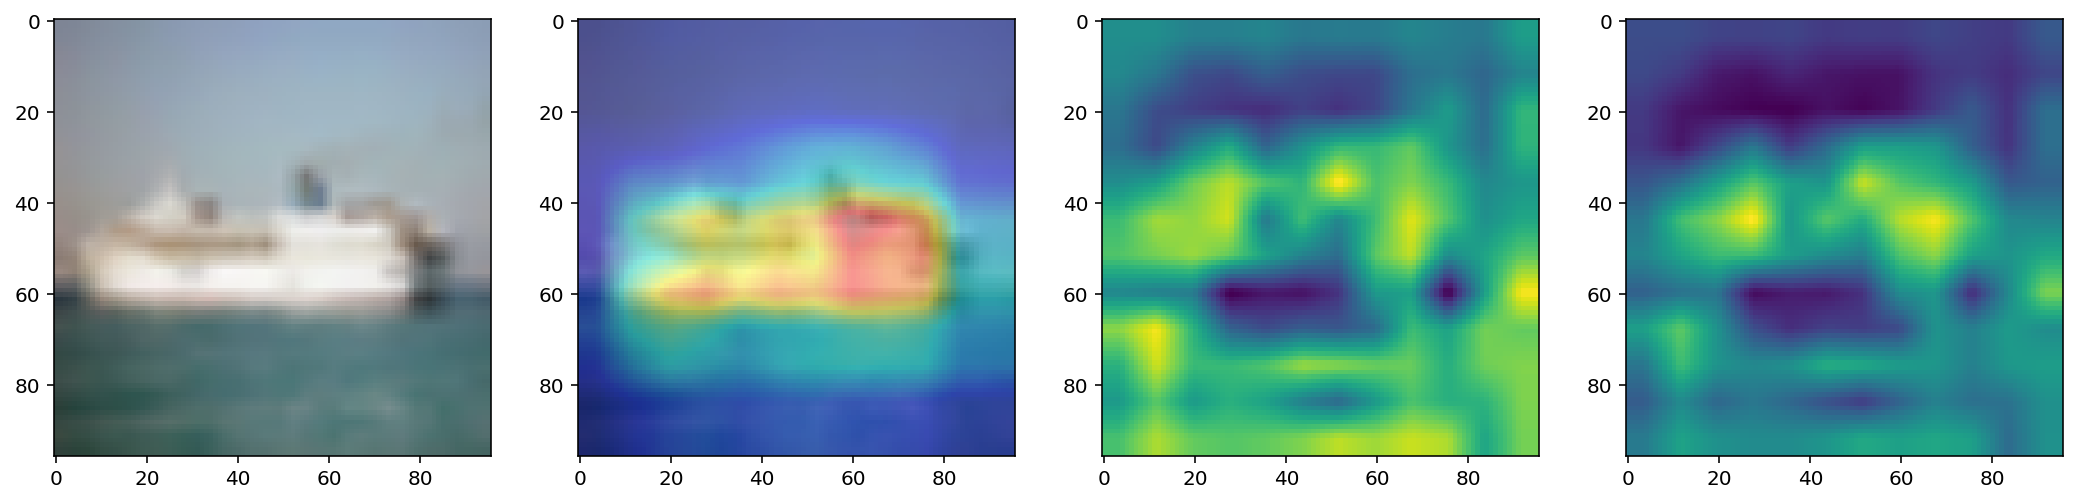

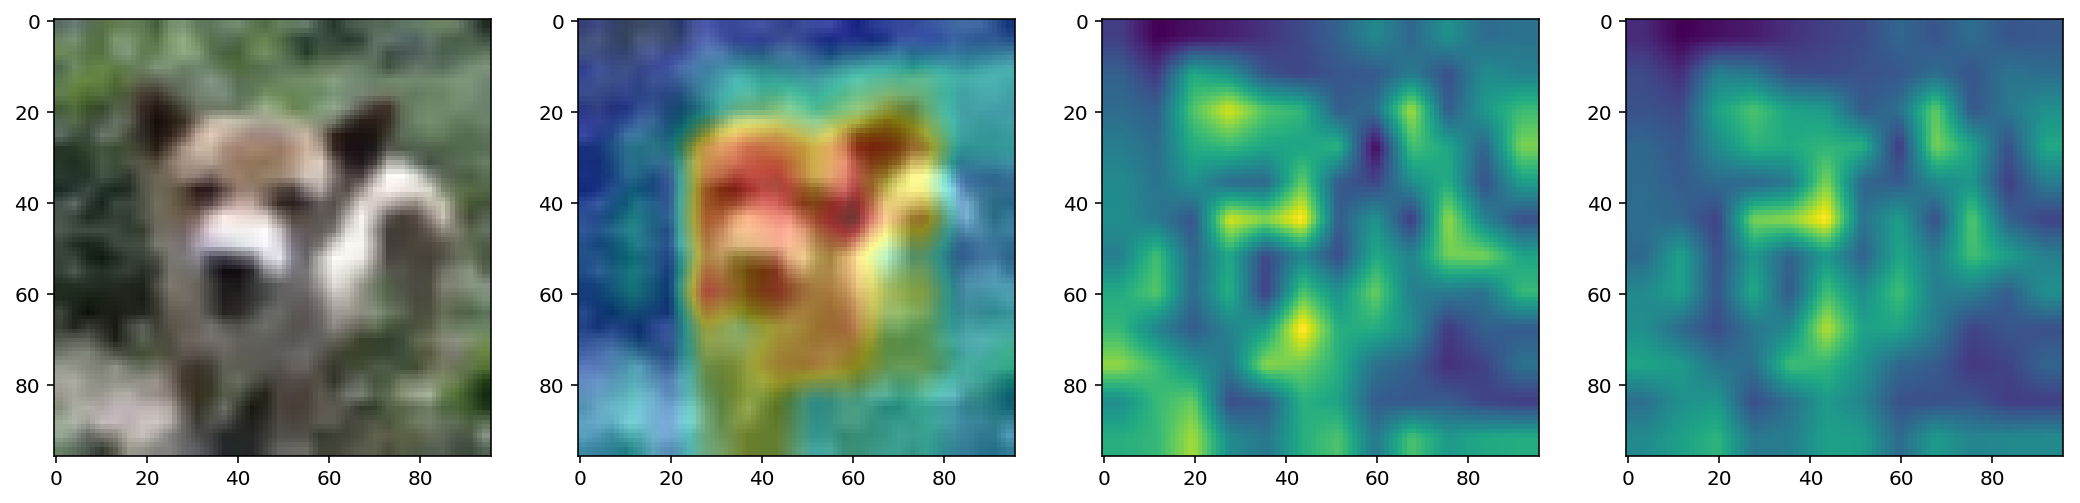

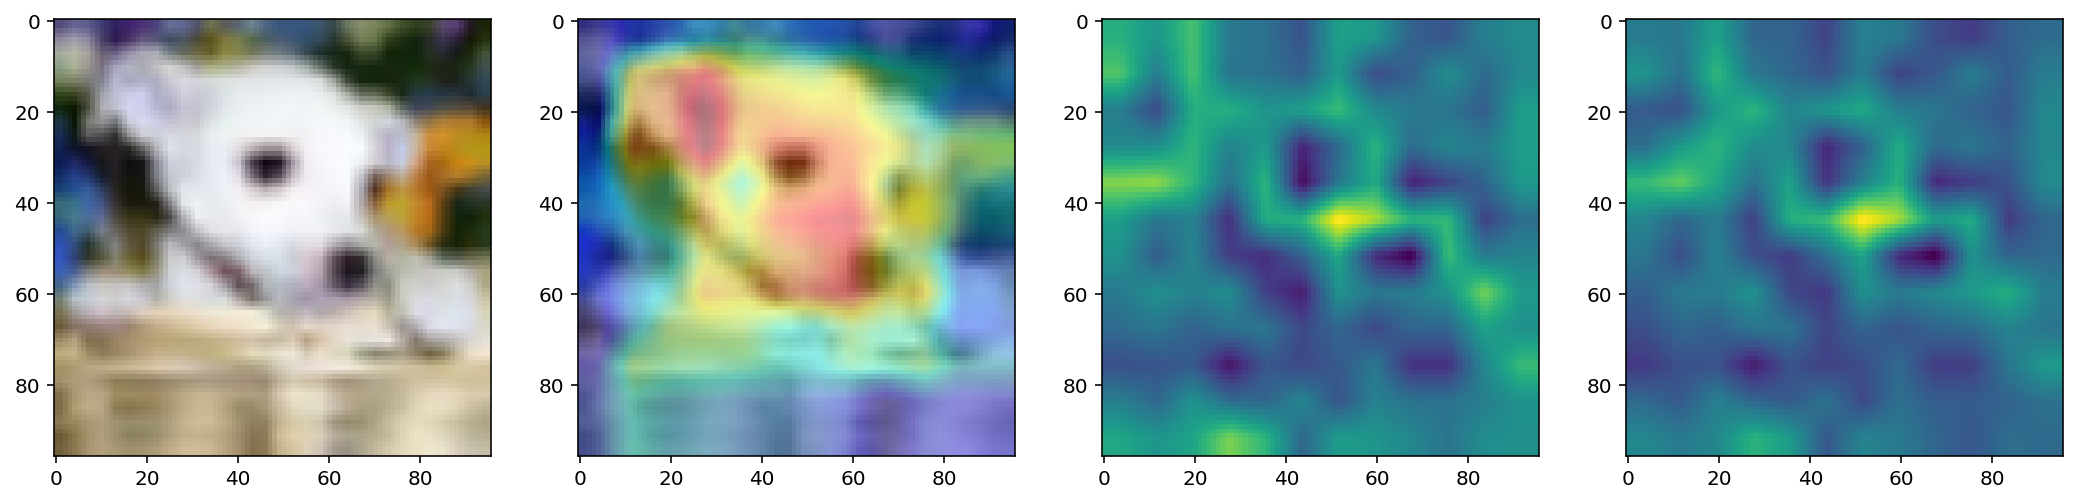

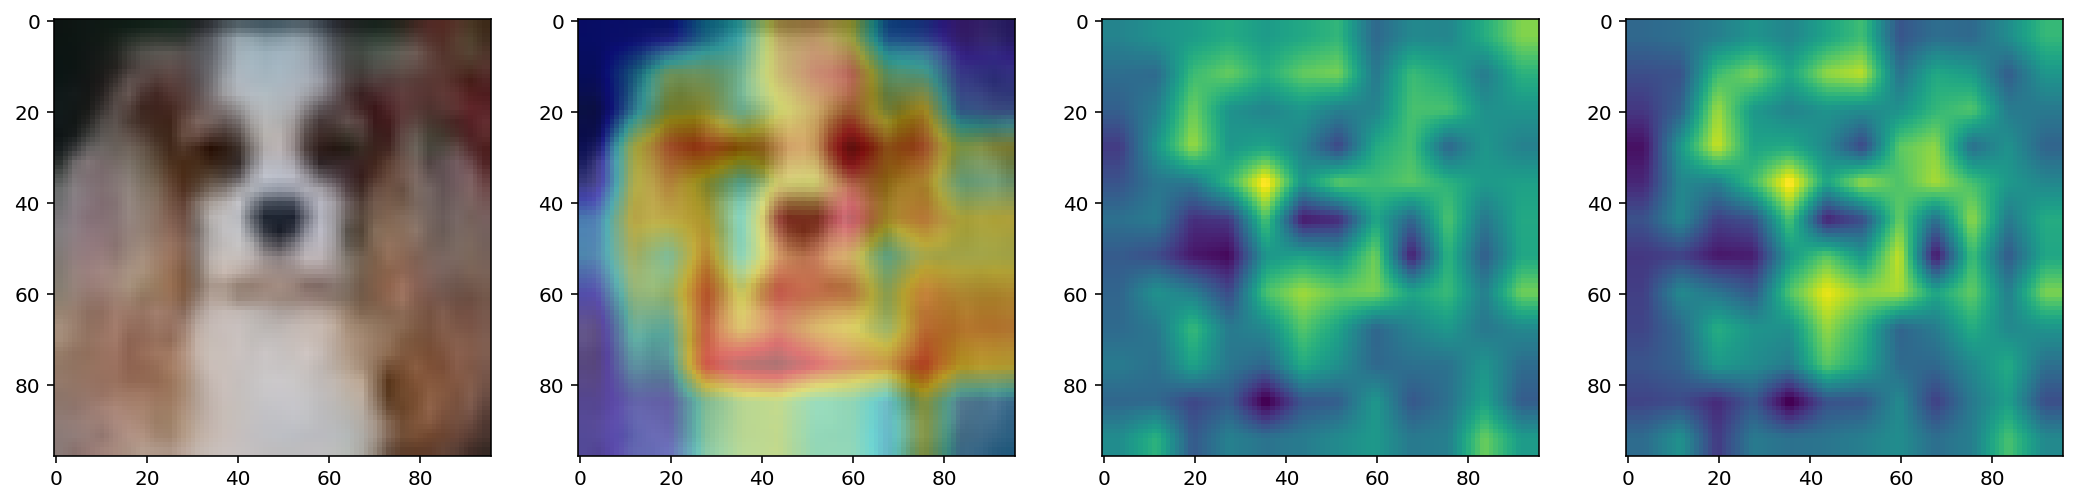

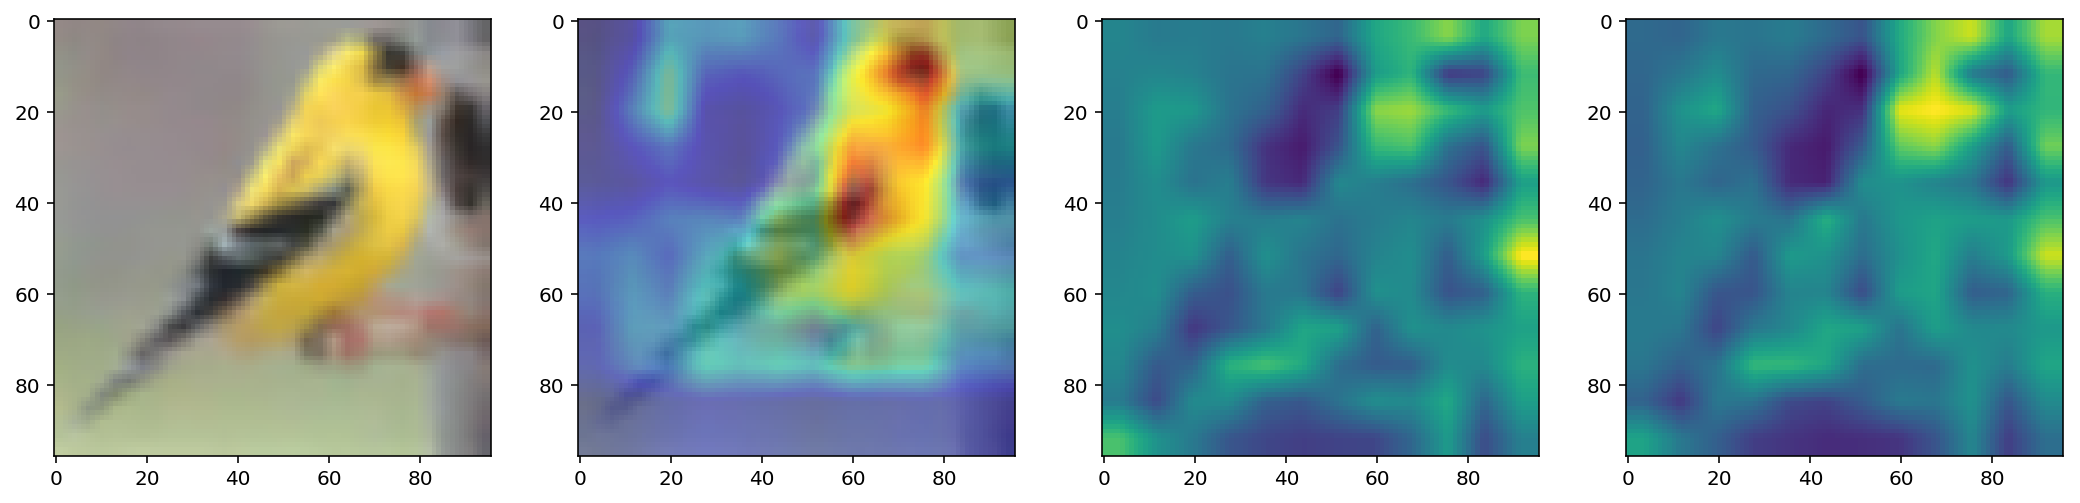

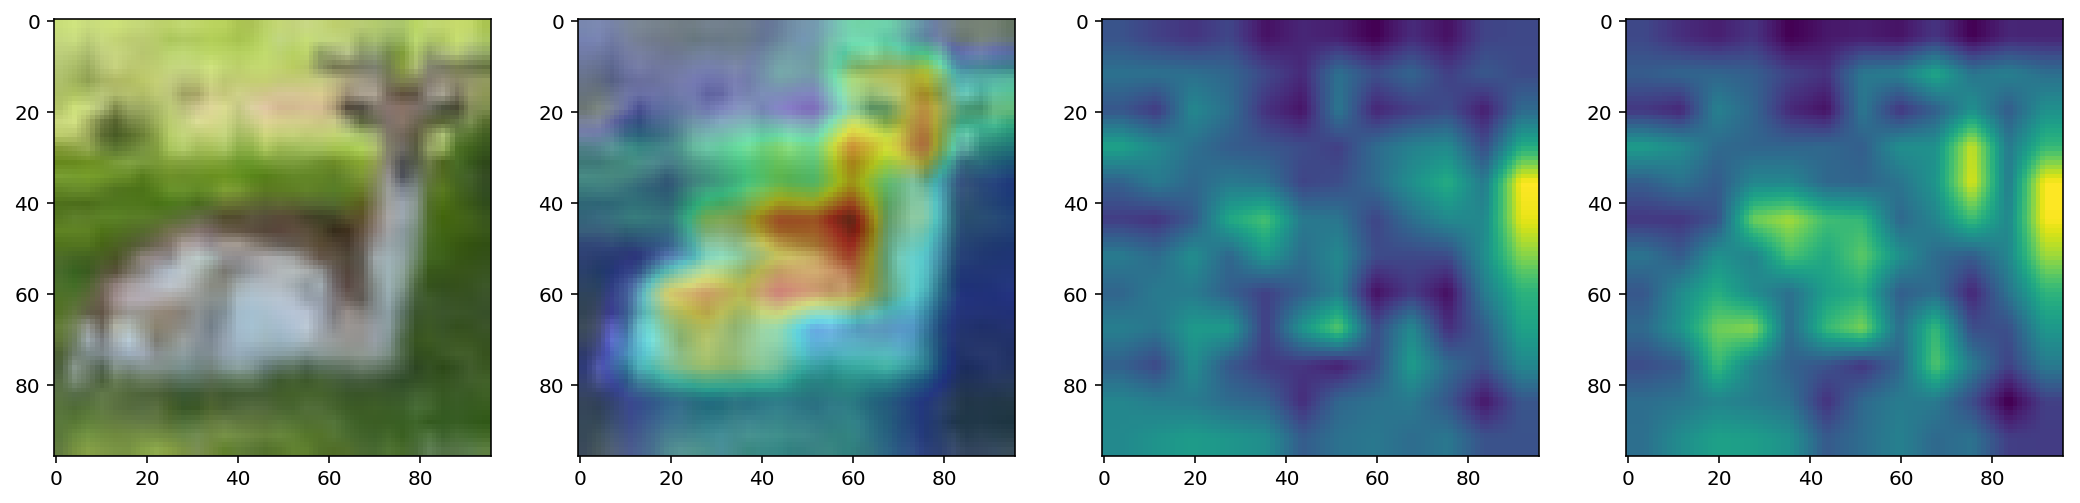

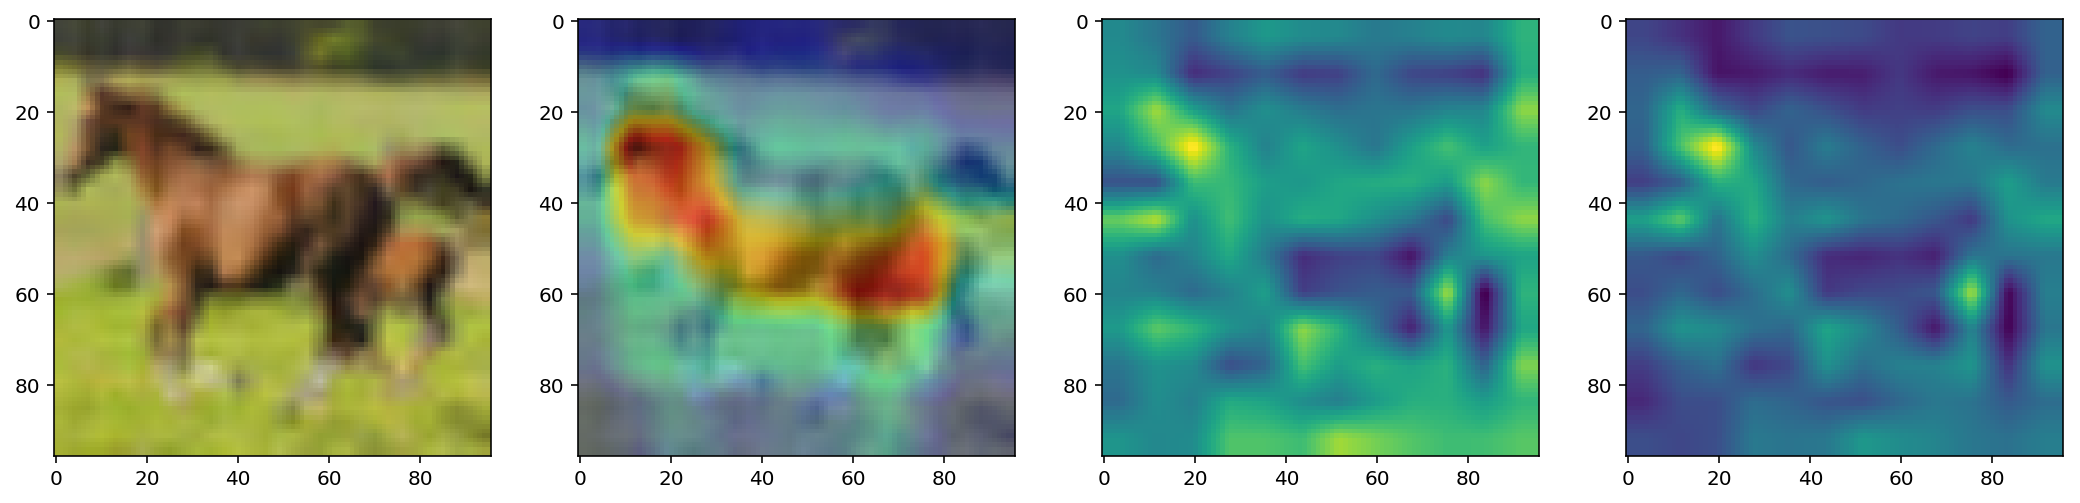

In [11]:
for i in np.random.randint(len(X_train),size=10):
    display(X_train[i],channel=0)